# DaskでOut-of-Core DataFrameを扱う

元記事: [Out-of-Core Dataframes in Python: Dask and OpenStreetMap](https://jakevdp.github.io/blog/2015/08/14/out-of-core-dataframes-in-python/)

※最後まで通してみたけど特にOut-of-Core DataFrameの話には触れられてません

## Daskとは

連結配列やデータフレームを様々なバックエンドを通じて扱うための軽量フレームワーク  
Python, Numpy, Pandasのコマンドが各チャンク上で使えて，マシンメモリを超える大きなデータセットを扱う事もできる  
インストールは以下の通り

```
$ pip install dask toolz
```

※後ほどグラフを描画するので，必要であれば以下もインストールしておく

```
$ brew install graphviz
$ pip install graphviz
```

mapを描画したい場合は `basemap` もインストールしておく必要がある  
※ソースから入れる必要が有るため面倒．condaだとうまくいくらしい（ http://stackoverflow.com/questions/31899966/pip-install-vs-conda-install ）  
※インストール方法: https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-installing-matplotlib-and-basemap/

## Data

[OSM-x-tractor](http://osm-x-tractor.org/Data.aspx) の `OIWorld.csv` データをダウンロードする  
これは，Points Of Interest を集めたデータらしい．[Open Street Map](http://openstreetmap.org/) と組み合わせて使える

In [1]:
!wc -l POIWorld.csv

 9431462 POIWorld.csv


In [2]:
!du -mL POIWorld.csv

785	POIWorld.csv


785MBなので十分メモリに載るが，ここではあえて複数のマシンでこれを扱うことを考える

## Daskの基本

- dask.bag: functional programming形式でタスクのグラフを作成する
- dask.array: Numpyのarray形式でタスクのグラフを作成する
- dask.dataframe: pandasのデータフレーム形式でタスクのグラフを作成する

In [3]:
# numpyのarrayとDaskのarrayを比較

import numpy as np
import dask.array as da

a = np.random.randn(1000)
b = a * 4
print(b.min())

a2 = da.from_array(a, chunks=200)
b2 = a2 * 4
print(b2.min().compute())  # compute()が呼ばれるまで処理が行われないことに注意

-15.4549179659
-15.4549179659


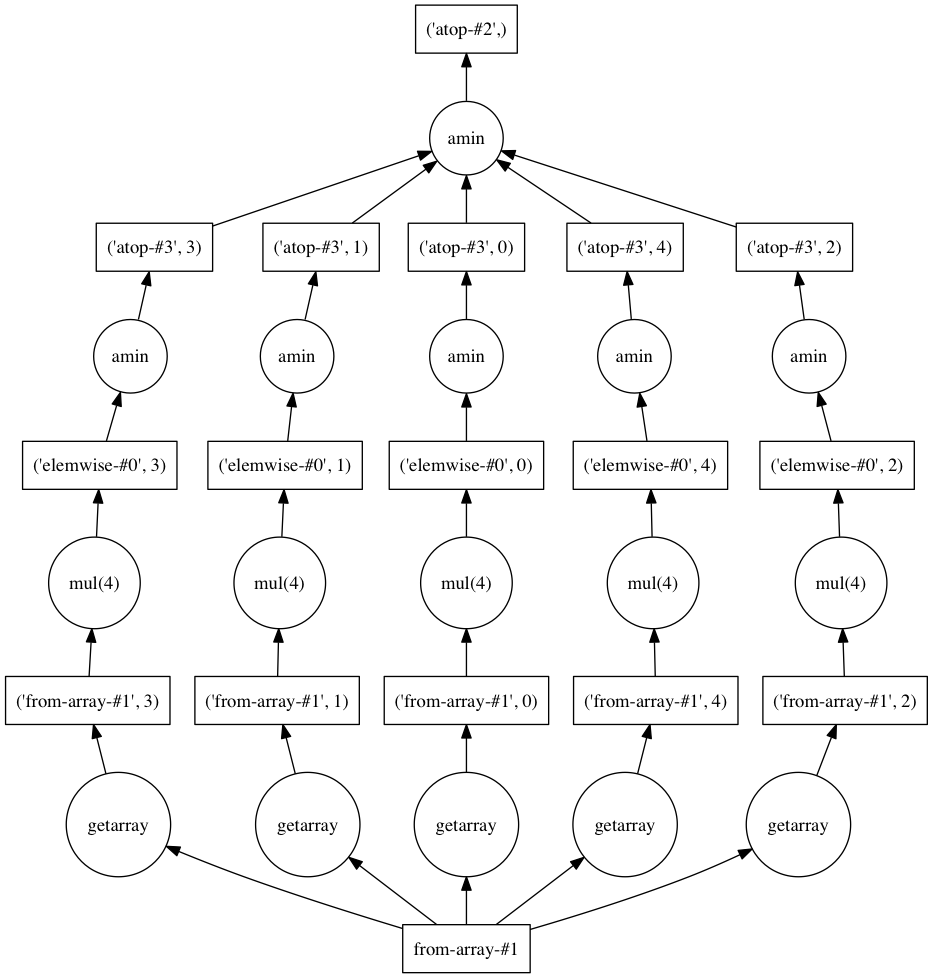

In [4]:
from dask.dot import dot_graph
dot_graph(b2.min().dask)

下から上に読む

- `dd.from_array` を使って `array` x を取得
- 5つのチャンクに分割 (1つのチャンクは200の要素を持つ)
- 各チャンク毎に4がかけられる
- 各チャンク毎に最小値を見つける
- 各チャンクの最小値を集めて全体の最小値を見つける
- それを結果として返す

## Dask DataFrame

OpenStreetMapのデータを利用して，pandasのDataFrameとDaskのDataFrameを比較

In [5]:
from dask import dataframe as dd
import pandas as pd

data = pd.read_csv('POIWorld.csv', nrows=5)
print(data.columns)

columns = ["name", "amenity", "Longitude", "Latitude"]
data = dd.read_csv('POIWorld.csv', usecols=columns)
print(data)

Index(['﻿"osmid"', 'name', 'amenity', 'emergency', 'historic', 'leisure',
       'man_made', 'office', 'shop', 'sport', 'tourism', 'craft', 'Longitude',
       'Latitude'],
      dtype='object')
dd.DataFrame<read-csv-POIWorld.csv-b53b3dcd90974b5d29d02664a368bf73, divisions=(None, None, None, ..., None, None)>


`dd.read_csv` コマンドは，実際にはファイルをopenしてデータにアクセスするなどの処理は行っていない  
どのような処理が行われるかは上記と同様に `dask` コマンドで確認できる

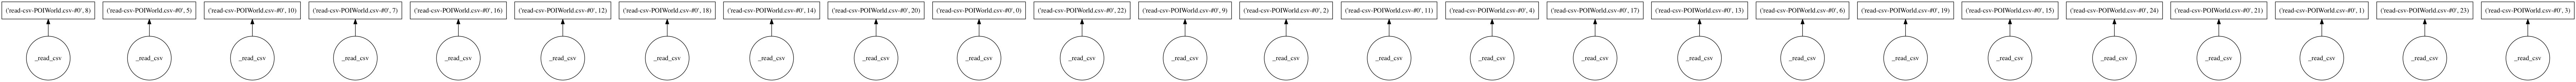

In [6]:
dot_graph(data.dask)

フィルタリングの処理なども行うことができる．繰り返すが処理は実行されてはいない

In [7]:
with_name = data[data.name.notnull()]        # 名前がnullじゃない
with_amenity = data[data.amenity.notnull()]  # 施設の項目がnullじゃない

## コーヒーの分布について調べてみる

アメリカの Starbucks と Dunkin Donuts の位置について調査する

In [8]:
# bool
is_starbucks = with_name.name.str.contains('[Ss]tarbucks')
is_dunkin = with_name.name.str.contains('[Dd]unkin')

# filtering
starbucks = with_name[is_starbucks]
dunkin = with_name[is_dunkin]

# ここでデータを読み込んで計算する処理が行われる
dd.compute(starbucks.name.count(), dunkin.name.count())

(5500, 1337)

In [9]:
dot_graph(starbucks.name.count().dask)

`dd.compute` をシングル呼び出しした場合，データは1回だけしか呼ばれない

In [10]:
# データの呼び出しは1回だけ
locs = dd.compute(starbucks.Longitude,
                  starbucks.Latitude,
                  dunkin.Longitude,
                  dunkin.Latitude)

lon_s, lat_s, lon_d, lat_d = [loc.values for loc in locs]

上記結果を描画してみる

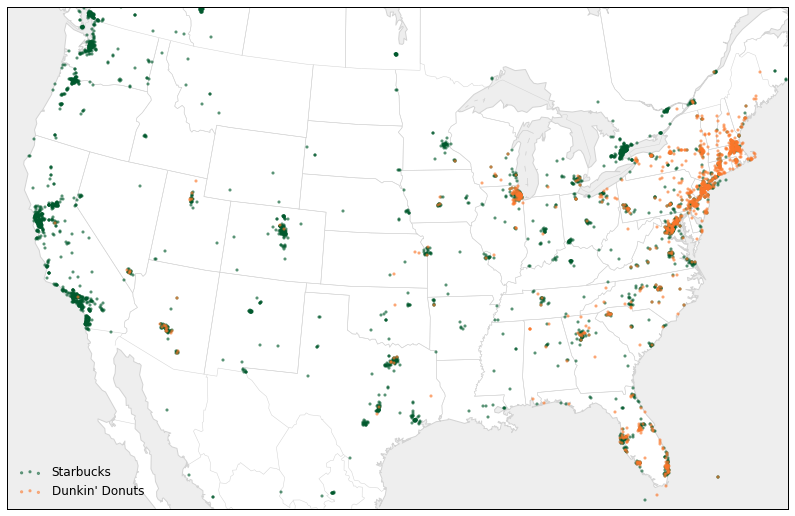

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def draw_USA():
    plt.figure(figsize=(14, 10))
    return Basemap(projection='lcc', resolution='l',
                   llcrnrlon=-119, urcrnrlon=-64,
                   llcrnrlat=22, urcrnrlat=49,
                   lat_1=33, lat_2=45, lon_0=-95,
                   area_thresh=10000)

m = draw_USA()

m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')

style = dict(s=5, marker='o', alpha=0.5, zorder=2)
m.scatter(lon_s, lat_s, latlon=True,
          label="Starbucks", color='#00592D', **style)
m.scatter(lon_d, lat_d, latlon=True,
          label="Dunkin' Donuts", color='#FC772A', **style)
plt.legend(loc='lower left', frameon=False);

## ファストフード店について調べる

In [12]:
print(dd.compute(with_amenity.amenity.count()))  # 施設の総カウント
with_amenity.amenity.value_counts().head(20)     # 各施設の数をカウントして上位20件を表示

(5216440,)


bench               516947
restaurant          413607
place_of_worship    392109
school              336972
parking             286076
fuel                202401
post_box            186465
cafe                162856
bank                155971
fast_food           152173
recycling           139401
pharmacy            131175
waste_basket        128006
grave_yard          117831
bicycle_parking     116216
post_office         103998
drinking_water      100140
toilets              97440
pub                  95648
telephone            91916
dtype: int64

ファストフードに着目して，どのファストフードレストランがより一般的なのか調べる

In [13]:
is_fastfood = with_amenity.amenity.str.contains('fast_food')
fastfood = with_amenity[is_fastfood]
fastfood.name.value_counts().head(12)

McDonald's        8697
Subway            7058
Burger King       3226
KFC               2881
Wendy's           1304
Taco Bell         1282
Pizza Hut         1014
マクドナルド             927
Dairy Queen        745
Domino's Pizza     724
McDonalds          619
Arby's             609
dtype: int64

これらのファストフード店について，先ほどと同様にmap上に描画する

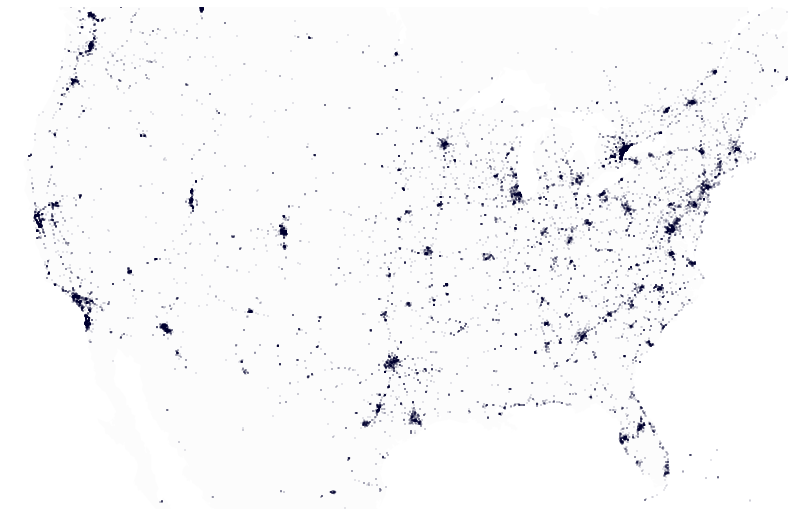

In [14]:
lat, lon = dd.compute(fastfood.Latitude,
                      fastfood.Longitude)

m = draw_USA()
    
m.drawmapboundary(fill_color='#ffffff', linewidth=0)
m.fillcontinents(color="#fcfcfc", lake_color='#ffffff', zorder=1)

m.scatter(lon.values, lat.values, latlon=True,
          s=1, marker='o', alpha=0.1, zorder=2)

## イギリス諸島のパブについて調べる

総カウント数を調査

In [15]:
is_pub = with_amenity.amenity.str.contains(r'\bpub\b')
pubs = with_amenity[is_pub]
pubs.amenity.count().compute()

95713

先ほどと同様にmap上に描画する

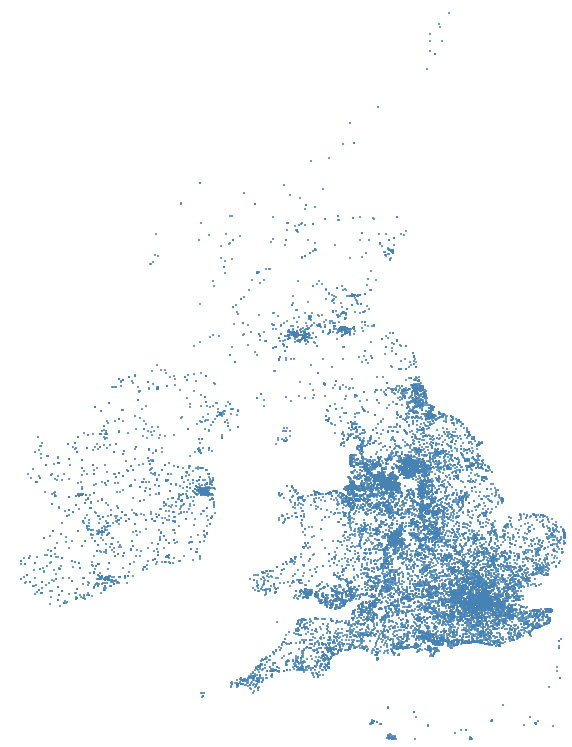

In [16]:
lon, lat = dd.compute(pubs.Longitude, pubs.Latitude)

fig, ax = plt.subplots(figsize=(10, 15))
m = Basemap(projection='mill',
            lon_0=-5.23636, lat_0=53.866772,
            llcrnrlon=-10.65073, llcrnrlat=49.16209,
            urcrnrlon=1.76334, urcrnrlat=60.860699)
m.drawmapboundary(fill_color='#ffffff', linewidth=.0)
x, y = m(lon.values, lat.values)
m.scatter(x, y, s=1, marker=',', color="steelblue", alpha=0.8)